In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import sys
sys.path.append("../src")

import utils
from NaCL import NaCL2

## Loading The Dataset

In [2]:
# This specifies the one_hot_encoding used for the adult dataset
#  For example [0, 1, 2, 3, 4] means the features 0-4 correspond to first feature of adult.
#  We need this because during missing-ness experiments as we want all related features to be missing at the same time

adult_one_hot_encoding = [[0, 1, 2, 3, 4],[5, 6, 7, 8, 9, 10, 11, 12, 13],[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],[46, 47, 48, 49, 50, 51, 52],[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],[68, 69, 70, 71, 72, 73],[74, 75, 76, 77, 78],[79, 80],[81, 82, 83, 84, 85],[86, 87, 88, 89, 90],[91, 92, 93, 94, 95],[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]]

In [3]:
X_train, y_train, X_test, y_test = utils.load_dataset("../data/adult_income", "adult")

### Learning Logistic Regression

In [4]:
clf = LogisticRegression(solver='lbfgs', 
    verbose=True, 
    C = 0.1,
    max_iter=2000, n_jobs=6).fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   12.8s finished


In [5]:
print("LR Train Accuracy: {} \nLR Test  Accuracy: {}".format(np.average(clf.predict(X_train) == y_train), 
                                                     np.average(clf.predict(X_test) == y_test)))

LR Train Accuracy: 0.8570331695331695 
LR Test  Accuracy: 0.8555487305487306


### Learning NaCL

In [6]:
%%time

# But if you do not have Mosek solver installed you can set `have_mosek = False` below.
#   1) It would take longer, probably around 1 minute for this dataset (vs ~0.12 for Mosek). 
#   2) Sometimes the solver might be unstable and give "not optimal" warning, 
#      however for our usecase you can ignore the warning and continue running the notebook
#
have_mosek = True # set False if you don't have mosek installed

nacl = NaCL2().setup(clf, X_train, y_train)
if have_mosek:
    nacl.solve(solver = 'mosek_conif', verbose=1) 
else:
    nacl.solve(solver = 'cvxopt', verbose=1) 

Using solver 'mosek_conif'
 for 554 free variables
  in 556 posynomial inequalities.
Solving took 0.232 seconds.
CPU times: user 1.68 s, sys: 516 ms, total: 2.19 s
Wall time: 1.17 s


In [8]:
# Sanity Check to compare NaCL results with Logistic Regression
assert(1.0 == np.average( nacl.predict(X_test)  == clf.predict(X_test )))
assert(1.0 == np.average( nacl.predict(X_train) == clf.predict(X_train)))

print("NaCL Train Accuracy: {} \nNaCL Test  Accuracy: {}".format(np.average(nacl.predict(X_train) == y_train), 
                                                     np.average(nacl.predict(X_test) == y_test)))

NaCL Train Accuracy: 0.8570331695331695 
NaCL Test  Accuracy: 0.8555487305487306


Now Let us compare accuracy with a directly trained Naive Bayes model. As we see the accuracy is lower.

In [9]:
NB = BernoulliNB().fit(X_train, y_train)
print("NB Train Accuracy: {} \nNB Test  Accuracy: {}".format(np.average(NB.predict(X_train) == y_train), 
                                                     np.average(NB.predict(X_test) == y_test)))

NB Train Accuracy: 0.8059479934479934 
NB Test  Accuracy: 0.8067158067158067


## Inference with NaCL
### All features observed

NaCL gives us a naive Bayes model that is conformant to our original Logistic Regression model so when no features are missing both models are equivalant down to probability level, for example:

In [10]:
nacl.predict_proba(X_test[0:3])[:,1] 

array([0.19363203, 0.01358296, 0.39921233])

In [11]:
clf.predict_proba(X_test[0:3])[:,1] 

array([0.19363203, 0.01358296, 0.39921233])

### Some features missing

Now when we have missing features, the Logistic Regression model is undefined and only option is to replace missing features with some value (i.e. do imputation) and then feed it to the model. On the other hand, inference in NaCL is defined and can be used to do prediction. Also the inference is effiecent no matter how many features are missing.

In [13]:
# Make an example observations with some missing features
missing_mask = np.zeros(X_test[0:3].shape)
miss = np.array([ [0, 10], [1, 2, 5, 10], [2,3,12] ], dtype=object)
for i in range(len(missing_mask)):
    for j in range(len(miss[i])):
        missing_mask[i][adult_one_hot_encoding[miss[i][j]]] = 1

In [14]:
nacl.predict_proba(X_test[0:3], missing = missing_mask)[:,1]

array([0.12917432, 0.03997081, 0.48769281])

## Missing Features Experiments

In [15]:
%%time
setting = {
    "repeat": 5, # 100
    "k": [i for i in range(0, 14, 1)],
    "prob" : True,
    "function": utils.conditional_likelihood_k,
    "feature_encoding": adult_one_hot_encoding,
    "verbose": False
}
data_a2 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

CPU times: user 2min 11s, sys: 1min 9s, total: 3min 20s
Wall time: 52.6 s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

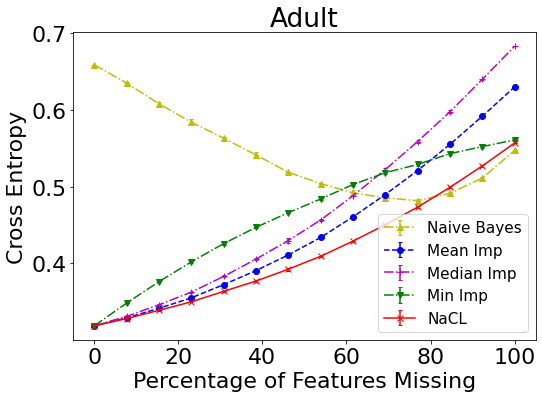

In [16]:
setting = {
    "show": ["min", "mean", "median", "ours", "nb"],
    "saveAs": "../results/demo_cross.pdf",
    "title": "Adult",
    "Ylabel": "Cross Entropy"
}
utils.plot_results_paper(data_a2, setting)

In [17]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "micro")

setting = {
    "repeat": 7, # 100
    "k": [i for i in range(0, 14, 1)],
    "prob" : False,
    "function": f1,
    "feature_encoding": adult_one_hot_encoding,
    "verbose": False
}
data_a3 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

CPU times: user 4min 55s, sys: 3min 10s, total: 8min 5s
Wall time: 1min 27s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

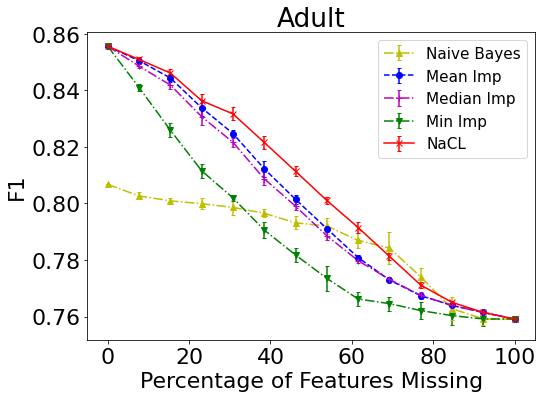

In [18]:
setting = {
    "show": ["min", "ours", "mean", "median" , "nb"],
    "saveAs": "../results/demo_accuracy.pdf",
    "title": "Adult",
    "Ylabel": "F1"
}
utils.plot_results_paper(data_a3, setting)